# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [3]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [45 lines of output]
      /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/setuptools/_distutils/dist.py:261: UserWarning: Unknown distribution option: 'test_suite'
        warnings.warn(msg)
      /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/setuptools/_distutils/dist.py:261: UserWarning: Unknown distribution option: 'tests_require'
        warnings.warn(msg)
      running egg_info
      creating /tmp/pip-pip-egg-info-m4kd6v6a/pyinstrument_cext.egg-info
      writing /tmp/pip-pip-egg-info-m4kd6v6a/pyinstrument_cext.egg-info/PKG-INFO
      writing dependency_links to /tmp/pip-pip-egg-info-m4kd6v6a/pyinstrument_cext.egg-info/dependency_links.txt
      writing top-level names to /tmp/pip-pip-egg-info-m4kd6v6a/pyinstrument_cext.egg-info/top_level.txt
      writing manifest file '/tmp/pip-pi

In [1]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import os
import io
import boto3
import random
import sagemaker
from PIL import Image
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
import matplotlib.pyplot as plt
from sagemaker.pytorch import PyTorch
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor
from IPython.display import clear_output
from sagemaker.debugger import (
    CollectionConfig,
    Rule,
    ProfilerRule,
    rule_configs,
    DebuggerHookConfig,
    ProfilerConfig,
    FrameworkProfile
)
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys



/home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[12/01/24 10:24:47] INFO     Found credentials from IAM Role:                                   ]8;id=893937;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=929994;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
[2024-12-01 10:24:51.385 ip-172-16-126-108.ec2.internal:5513 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [ ]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

clear_output()

In [12]:
session = boto3.session.Session()
region = session.region_name
s3_resource = boto3.resource("s3", region_name=region)

def upload_objects(
    s3_bucket_name,  #s3 bucket name
    s3_prefix,  #s3 prefix name
    root_path   # local folder for upload
):
    try:
        my_bucket = s3_resource.Bucket(s3_bucket_name)

        for path, subdirs, files in os.walk(root_path):
            path = path.replace("\\","/")
            directory_name = path.replace(root_path,"")
            for file in files:
                my_bucket.upload_file(
                    os.path.join(path, file),
                    s3_prefix+'/'+directory_name+'/'+file
                )

    except Exception as err:
        print(err)


upload_objects("hoangtrung-course-4", "dogImages-dataset", "./dogImages/")

print('Upload success')

Upload success


#### Explore Dataset

In [41]:
# Extract dataset details
def analyze_dataset(root_dir):
    dataset_info = {
        'train': {},
        'test': {},
        'valid': {}
    }

    for dataset_type in ['train', 'test', 'valid']:
        dataset_path = os.path.join(root_dir, dataset_type)
        for breed_folder in os.listdir(dataset_path):
            breed_folder_path = os.path.join(dataset_path, breed_folder)
            if os.path.isdir(breed_folder_path):
                num_images = len([file for file in os.listdir(breed_folder_path) if file.endswith('.jpg')])
                breed_name = breed_folder.split('.')[1]
                dataset_info[dataset_type][breed_name] = num_images

    return dataset_info

dataset_info = analyze_dataset('dogImages')
print("Total number of dog species:", len(dataset_info['train']))
print("\nDataset infor", dataset_info['train'])

Total number of dog species: 133

Dataset infor {'Kuvasz': 49, 'Airedale_terrier': 52, 'German_pinscher': 47, 'English_toy_spaniel': 39, 'Plott': 28, 'Great_dane': 40, 'Lowchen': 34, 'Yorkshire_terrier': 30, 'American_staffordshire_terrier': 66, 'Australian_shepherd': 66, 'Cavalier_king_charles_spaniel': 67, 'Ibizan_hound': 46, 'Icelandic_sheepdog': 50, 'Norwegian_elkhound': 45, 'Giant_schnauzer': 41, 'Basenji': 69, 'English_cocker_spaniel': 61, 'Belgian_sheepdog': 64, 'Pomeranian': 44, 'Norwegian_buhund': 26, 'Smooth_fox_terrier': 30, 'Irish_water_spaniel': 51, 'Chesapeake_bay_retriever': 54, 'Australian_cattle_dog': 66, 'Kerry_blue_terrier': 35, 'Entlebucher_mountain_dog': 42, 'Silky_terrier': 41, 'Irish_terrier': 66, 'Otterhound': 35, 'Bullmastiff': 69, 'Boykin_spaniel': 53, 'Miniature_schnauzer': 42, 'Collie': 57, 'Boston_terrier': 65, 'Pointer': 32, 'Chihuahua': 54, 'German_shorthaired_pointer': 48, 'Black_russian_terrier': 41, 'Bearded_collie': 62, 'Greyhound': 56, 'Boxer': 64, '

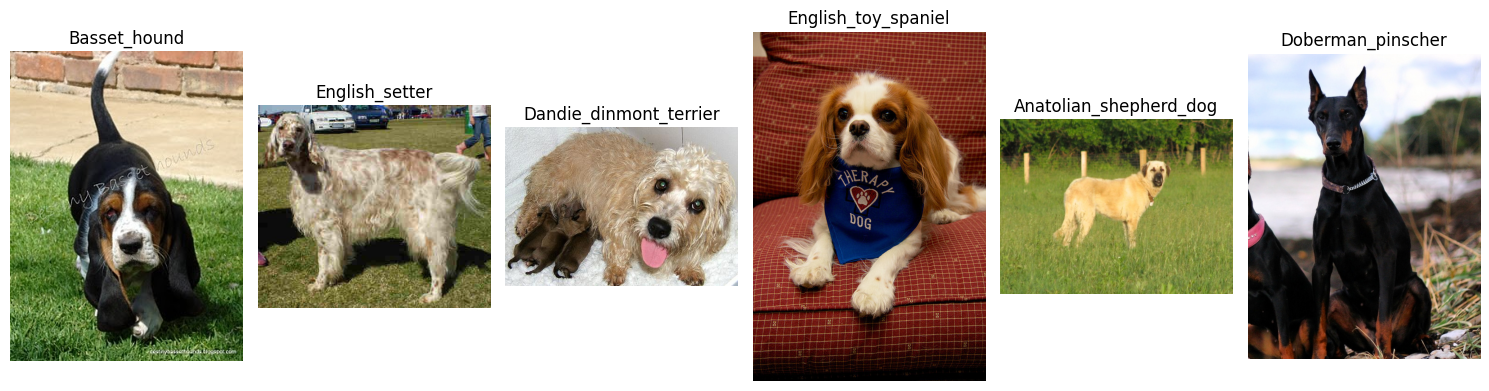

In [48]:
# Show image exmaples
def plot_sample_images(dataset_info, root_dir, data_type, n=3):
    train_dir = os.path.join(root_dir, data_type)
    breeds = os.listdir(train_dir)
    selected_breeds = random.sample(breeds, n)
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    for i, breed in enumerate(selected_breeds):
        breed_name = breed.split('.')[1]  # Tên loài
        breed_folder = os.path.join(train_dir, breed)
        image_file = random.choice(os.listdir(breed_folder))
        image_path = os.path.join(breed_folder, image_file)
        img = Image.open(image_path)
        axes[i].imshow(img)
        axes[i].set_title(breed_name)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

plot_sample_images(dataset_info, 'dogImages', 'train', n=6)

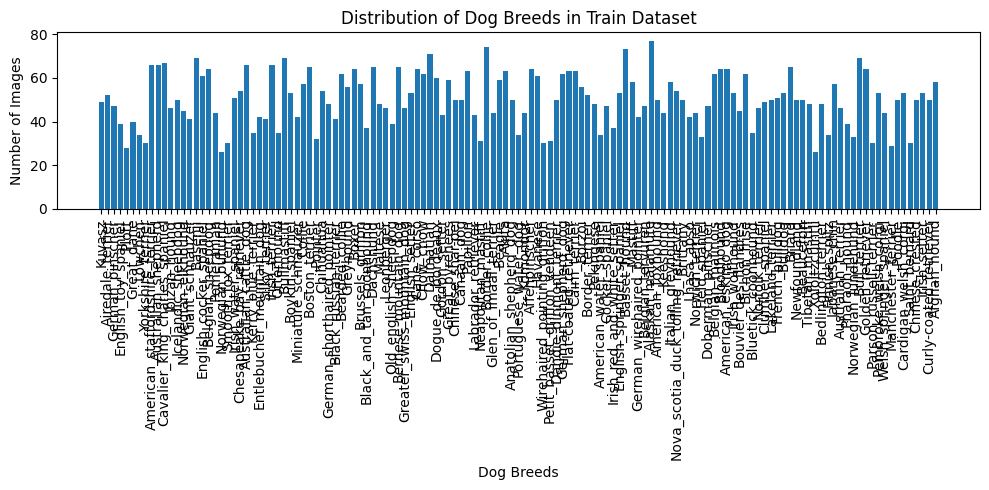

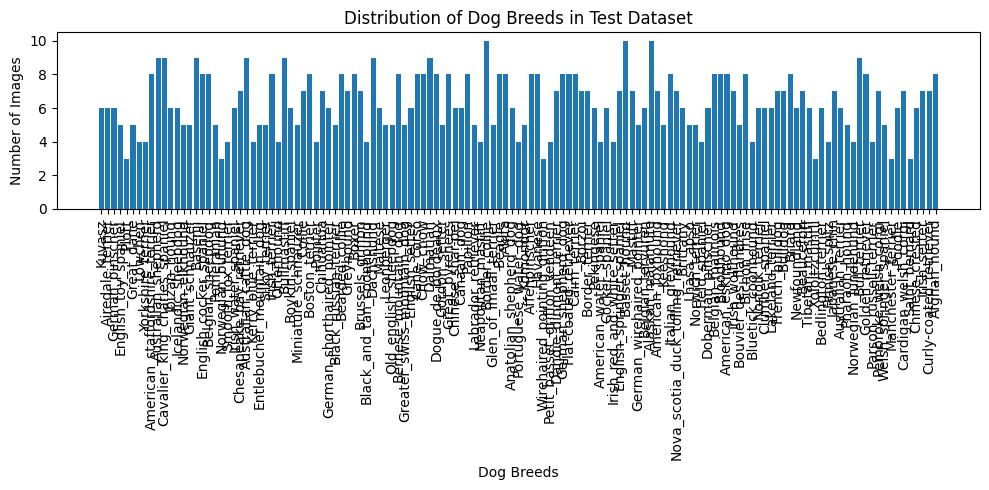

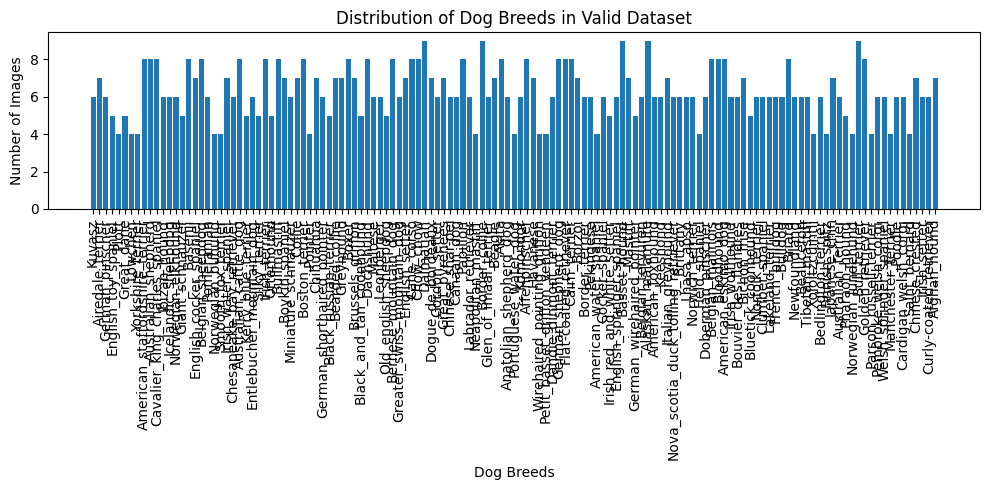

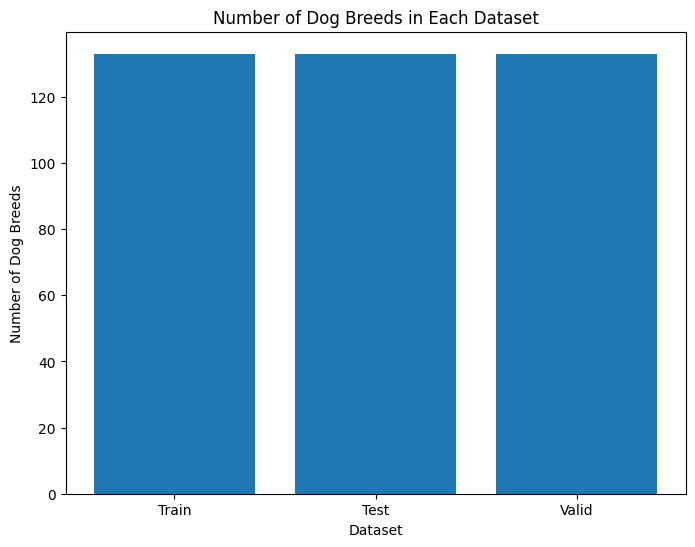

In [35]:
# Plot the number of species and the number of images in each species.
def plot_breed_distribution(dataset_info):
    for dataset_type in ['train', 'test', 'valid']:
        breeds = list(dataset_info[dataset_type].keys())
        num_images = list(dataset_info[dataset_type].values())
        plt.figure(figsize=(10, 5))
        plt.bar(breeds, num_images)
        plt.xticks(rotation=90)
        plt.title(f"Distribution of Dog Breeds in {dataset_type.capitalize()} Dataset")
        plt.xlabel('Dog Breeds')
        plt.ylabel('Number of Images')
        plt.tight_layout()
        plt.show()
    num_breeds_train = len(dataset_info['train'])
    num_breeds_test = len(dataset_info['test'])
    num_breeds_valid = len(dataset_info['valid'])
    plt.figure(figsize=(8, 6))
    plt.bar(['Train', 'Test', 'Valid'], [num_breeds_train, num_breeds_test, num_breeds_valid])
    plt.title("Number of Dog Breeds in Each Dataset")
    plt.xlabel('Dataset')
    plt.ylabel('Number of Dog Breeds')
    plt.show()

plot_breed_distribution(dataset_info)


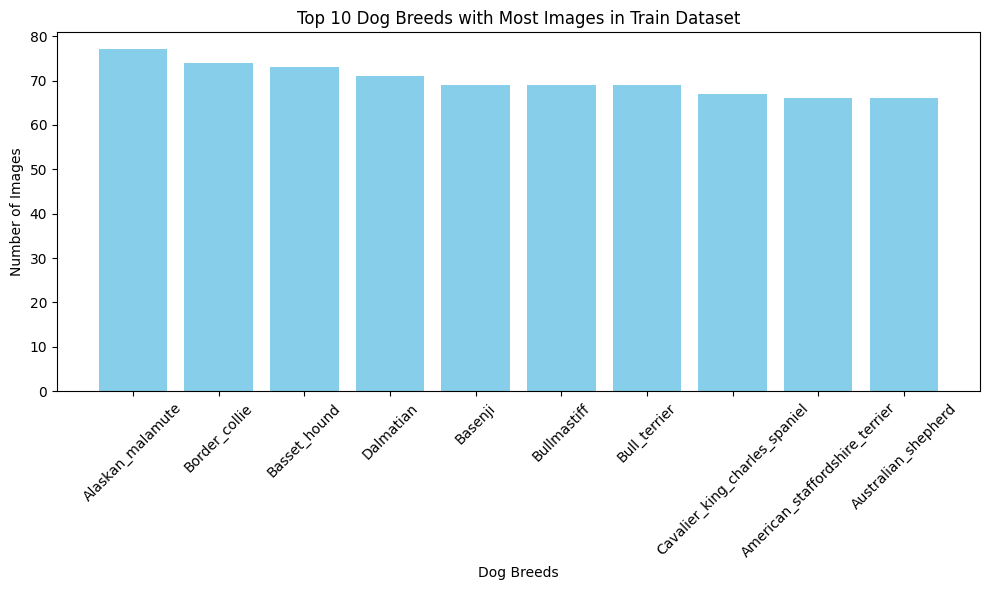

In [36]:
# Show top 10 dog breeds with the most number of images in the training set
def plot_top_n_breeds(dataset_info, dataset_type='train', n=10):
    breed_images = dataset_info[dataset_type]
    sorted_breeds = sorted(breed_images.items(), key=lambda item: item[1], reverse=True)[:n]
    breeds, num_images = zip(*sorted_breeds)
    plt.figure(figsize=(10, 6))
    plt.bar(breeds, num_images, color='skyblue')
    plt.xticks(rotation=45)
    plt.title(f"Top {n} Dog Breeds with Most Images in {dataset_type.capitalize()} Dataset")
    plt.xlabel('Dog Breeds')
    plt.ylabel('Number of Images')
    plt.tight_layout()
    plt.show()

plot_top_n_breeds(dataset_info, dataset_type='train', n=10)

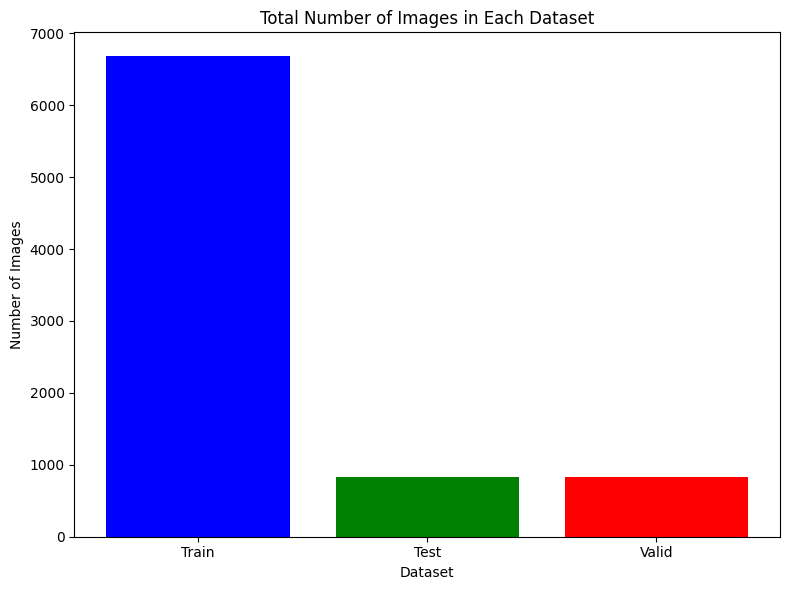

In [38]:
# Number of images of the entire train, test, and validation datasets
def plot_total_images_per_dataset(dataset_info):
    total_images_train = sum(dataset_info['train'].values())
    total_images_test = sum(dataset_info['test'].values())
    total_images_valid = sum(dataset_info['valid'].values())
    datasets = ['Train', 'Test', 'Valid']
    total_images = [total_images_train, total_images_test, total_images_valid]
    plt.figure(figsize=(8, 6))
    plt.bar(datasets, total_images, color=['blue', 'green', 'red'])
    plt.title("Total Number of Images in Each Dataset")
    plt.xlabel('Dataset')
    plt.ylabel('Number of Images')
    plt.tight_layout()
    plt.show()

plot_total_images_per_dataset(dataset_info)

sagemaker.get_execution_role()## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [2]:
sagemaker.get_execution_role()

[12/01/24 10:25:03] INFO     Found credentials from IAM Role:                                   ]8;id=654268;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=494148;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

'arn:aws:iam::804810208137:role/service-role/AmazonSageMaker-ExecutionRole-20240913T084376'

In [3]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.01, 0.1),
    "batch_size": CategoricalParameter([64, 128]),
    "epochs": IntegerParameter(5, 15),
}

In [4]:
#TODO: Create estimators for your HPs
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name="hyperparamater_turning",
    role=sagemaker.get_execution_role(),
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.2xlarge"
)

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

[12/01/24 10:25:21] INFO     Found credentials from IAM Role:                                   ]8;id=206451;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=869695;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

[12/01/24 10:25:22] INFO     Found credentials from IAM Role:                                   ]8;id=641155;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=72879;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Found credentials from IAM Role:                                   ]8;id=10194;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=909605;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

In [ ]:
# TODO: Fit your HP Tuner
s3_dataset = "s3://hoangtrung-course-4/dogImages-dataset/"
tuner.fit({'data': s3_dataset}, wait=True)

[12/01/24 10:25:26] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=839933;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=956654;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/image_uris.py#674\674]8;;\
                             instance_type, framework etc.                                                         

                    WARNING  No finished training job found associated with this estimator.       ]8;id=985556;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=115401;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/estimator.py#1909\1909]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    WARNING  No finished training job found associated with this estimator.       ]8;id=877791;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=401879;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/estimator.py#1909\1909]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=519927;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=916360;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/image_uris.py#674\674]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Creating hyperparameter tuning job with name:                          ]8;id=492597;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=480370;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/session.py#3314\3314]8;;\
                             pytorch-training-241201-1025                                                          

.................

In [10]:
tuner.describe()

{'HyperParameterTuningJobName': 'pytorch-training-241201-1025',
 'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:804810208137:hyper-parameter-tuning-job/pytorch-training-241201-1025',
 'HyperParameterTuningJobConfig': {'Strategy': 'Bayesian',
  'HyperParameterTuningJobObjective': {'Type': 'Minimize',
   'MetricName': 'average test loss'},
  'ResourceLimits': {'MaxNumberOfTrainingJobs': 4,
   'MaxParallelTrainingJobs': 2},
  'ParameterRanges': {'IntegerParameterRanges': [{'Name': 'epochs',
     'MinValue': '5',
     'MaxValue': '15',
     'ScalingType': 'Auto'}],
   'ContinuousParameterRanges': [{'Name': 'lr',
     'MinValue': '0.01',
     'MaxValue': '0.1',
     'ScalingType': 'Auto'}],
   'CategoricalParameterRanges': [{'Name': 'batch_size',
     'Values': ['"64"', '"128"']}]},
  'TrainingJobEarlyStoppingType': 'Off'},
 'TrainingJobDefinition': {'StaticHyperParameters': {'_tuning_objective_metric': 'average test loss',
   'sagemaker_container_log_level': '20',
   'sagemaker

In [11]:
# TODO: Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2024-12-01 11:54:59 Starting - Found matching resource for reuse
2024-12-01 11:54:59 Downloading - Downloading the training image
2024-12-01 11:54:59 Training - Training image download completed. Training in progress.
2024-12-01 11:54:59 Uploading - Uploading generated training model
2024-12-01 11:54:59 Completed - Resource released due to keep alive period expiry


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"128"',
 'epochs': '14',
 'lr': '0.027984540227056022',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"hyperparamater_turning-2024-12-01-10-25-26-151"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-804810208137/hyperparamater_turning-2024-12-01-10-25-26-151/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [12]:
# TODO: Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(num_steps=1)
)

debugger_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "100",
        "eval.save_interval": "10"
    },
    collection_configs=[
        CollectionConfig(
            name="CrossEntropyLoss_collection",
            parameters={
                "include_regex": "CrossEntropyLoss_output_0",
                "save_interval": "100"
            }
        )
    ]
)

[12/01/24 12:11:36] WARNING  Framework profiling will be deprecated from tensorflow 2.12 and     ]8;id=529558;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=891291;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             pytorch 2.0 in sagemaker>=2.                                                          
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

In [13]:
tuner_infor = tuner.describe()
tuning_job_name = tuner_infor['HyperParameterTuningJobName']
tuning_job_name

'pytorch-training-241201-1025'

In [ ]:
# TODO: Create and fit an estimator
tuner = HyperparameterTuner.attach(tuning_job_name)
best_hyperparameters = tuner.best_estimator().hyperparameters()

hyperparameters = {
    "batch_size": int(best_hyperparameters['batch_size'].strip('"')),
    "lr": float(best_hyperparameters['lr']),
    "epochs": int(best_hyperparameters['epochs'].strip('"'))
}

estimator = PyTorch(
    entry_point="train_model.py",
    # base_job_name="profiling_debugging",
    role=sagemaker.get_execution_role(),
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

s3_dataset = "s3://hoangtrung-course-4/dogImages-dataset/"
estimator.fit({'data': s3_dataset}, wait=True)


2024-12-01 11:54:59 Starting - Found matching resource for reuse
2024-12-01 11:54:59 Downloading - Downloading the training image
2024-12-01 11:54:59 Training - Training image download completed. Training in progress.
2024-12-01 11:54:59 Uploading - Uploading generated training model
2024-12-01 11:54:59 Completed - Resource released due to keep alive period expiry


[12/01/24 12:15:08] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=905147;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=108092;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/image_uris.py#674\674]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Defaulting to the only supported framework/algorithm version:        ]8;id=433960;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=270791;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/image_uris.py#487\487]8;;\
                             latest.                                                                               

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=355986;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=66739;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/image_uris.py#523\523]8;;\

                    INFO     Defaulting to the only supported framework/algorithm version:        ]8;id=793864;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=96172;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/image_uris.py#487\487]8;;\
                             latest.                                                                               

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=93267;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=228439;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/image_uris.py#523\523]8;;\

                    INFO     Defaulting to the only supported framework/algorithm version:        ]8;id=571688;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=713493;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/image_uris.py#487\487]8;;\
                             latest.                                                                               

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=250073;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=591458;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/image_uris.py#523\523]8;;\

                    INFO     Defaulting to the only supported framework/algorithm version:        ]8;id=544764;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=679004;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/image_uris.py#487\487]8;;\
                             latest.                                                                               

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=845881;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=145096;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/image_uris.py#523\523]8;;\

                    INFO     Defaulting to the only supported framework/algorithm version:        ]8;id=596453;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=238768;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/image_uris.py#487\487]8;;\
                             latest.                                                                               

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=409362;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=391579;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/image_uris.py#523\523]8;;\

                    INFO     Defaulting to the only supported framework/algorithm version:        ]8;id=578575;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=307300;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/image_uris.py#487\487]8;;\
                             latest.                                                                               

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=415815;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=279688;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/image_uris.py#523\523]8;;\

                    INFO     Defaulting to the only supported framework/algorithm version:        ]8;id=949289;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=433354;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/image_uris.py#487\487]8;;\
                             latest.                                                                               

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=461699;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=750158;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/image_uris.py#523\523]8;;\

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=795400;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=805231;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/image_uris.py#674\674]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Creating training-job with name:                                       ]8;id=889846;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=901216;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             pytorch-training-2024-12-01-12-15-08-456                                              

2024-12-01 12:15:10 Starting - Starting the training job...
2024-12-01 12:15:41 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
...
2024-12-01 12:16:01 Downloading - Downloading input data............
2024-12-01 12:18:12 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-12-01 12:18:16,183 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-12-01 12:18:16,186 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-12-01 12:18:16,196 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-12-01 12:18:16,201 sagemaker_pytorch_container.training INFO

In [18]:
est_hyperparams = estimator.hyperparameters()
training_job_name = est_hyperparams['sagemaker_job_name'].replace('"', '')
training_job_name

'pytorch-training-2024-12-01-12-15-08-456'

In [19]:
# TODO: Plot a debugging output.
client = boto3.client('sagemaker')
description = client.describe_training_job(TrainingJobName=training_job_name)
description


{'TrainingJobName': 'pytorch-training-2024-12-01-12-15-08-456',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:804810208137:training-job/pytorch-training-2024-12-01-12-15-08-456',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-804810208137/pytorch-training-2024-12-01-12-15-08-456/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'batch_size': '128',
  'epochs': '14',
  'lr': '0.027984540227056022',
  'sagemaker_container_log_level': '20',
  'sagemaker_job_name': '"pytorch-training-2024-12-01-12-15-08-456"',
  'sagemaker_program': '"train_model.py"',
  'sagemaker_region': '"us-east-1"',
  'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-804810208137/pytorch-training-2024-12-01-12-15-08-456/source/sourcedir.tar.gz"'},
 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:1.8-cpu-py36',
  'TrainingInputMode': 'File',
  'EnableSageMakerMetricsTimeS

In [20]:
estimator.latest_job_debugger_artifacts_path()

's3://sagemaker-us-east-1-804810208137/pytorch-training-2024-12-01-12-15-08-456/debug-output'

In [24]:
estimator.latest_job_profiler_artifacts_path()

's3://sagemaker-us-east-1-804810208137/pytorch-training-2024-12-01-12-15-08-456/profiler-output'

[2024-12-01 14:40:18.783 ip-172-16-126-108.ec2.internal:5513 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-804810208137/pytorch-training-2024-12-01-12-15-08-456/debug-output
[2024-12-01 14:40:19.581 ip-172-16-126-108.ec2.internal:5513 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-12-01 14:40:20.599 ip-172-16-126-108.ec2.internal:5513 INFO trial.py:210] Loaded all steps
<class 'dict'>
{0: array(5.1805024, dtype=float32), 100: array(5.43605, dtype=float32), 200: array(5.272637, dtype=float32), 300: array(5.031681, dtype=float32), 400: array(4.978537, dtype=float32), 500: array(4.95198, dtype=float32), 600: array(4.743006, dtype=float32), 700: array(5.011323, dtype=float32), 742: array(4.7369285, dtype=float32)}


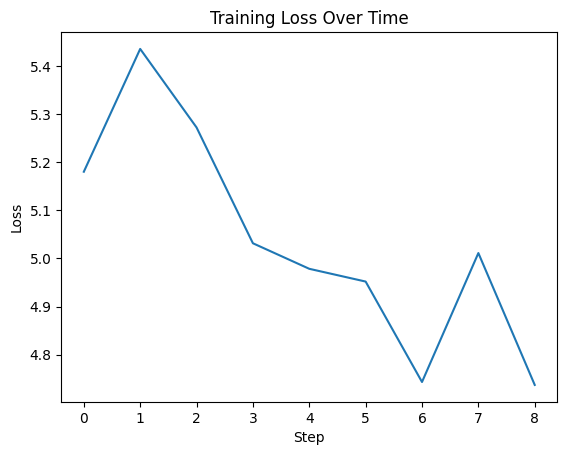

In [21]:
# TODO: Plot a debugging output.
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

loss_values = trial.tensor("CrossEntropyLoss_output_0").values()

print(type(loss_values))
print(loss_values)
if isinstance(loss_values, dict):
    loss_values = [v for v in loss_values.values()]
plt.plot(loss_values)
plt.title("Training Loss Over Time")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()

In [35]:
rule_output_path = "s3://sagemaker-us-east-1-804810208137/pytorch-training-2024-12-01-12-15-08-456/rule-output/"
! aws s3 ls {rule_output_path} --recursive

2024-12-01 14:27:34     375081 pytorch-training-2024-12-01-12-15-08-456/rule-output/ProfilerReport/profiler-output/profiler-report.html
2024-12-01 14:27:34     223014 pytorch-training-2024-12-01-12-15-08-456/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2024-12-01 14:27:29        193 pytorch-training-2024-12-01-12-15-08-456/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2024-12-01 14:27:29        201 pytorch-training-2024-12-01-12-15-08-456/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2024-12-01 14:27:29       1871 pytorch-training-2024-12-01-12-15-08-456/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2024-12-01 14:27:29        127 pytorch-training-2024-12-01-12-15-08-456/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2024-12-01 14:27:29        200 pytorch-training-2024-12-01-12-15-08-456/rule-output/ProfilerReport/profiler-output/profiler-re

In [36]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-804810208137/pytorch-training-2024-12-01-12-15-08-456/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-804810208137/pytorch-training-2024-12-01-12-15-08-456/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-804810208137/pytorch-training-2024-12-01-12-15-08-456/rule-output/ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json to ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json
download: s3://sagemaker-us-east-1-804810208137/pytorch-training-2024-12-01-12-15-08-456/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-804810208137/pytorch-training-2024-12-01-12-15-08-456/rule-outp

## Model Deploying

In [ ]:
# TODO: Deploy your model to an endpoint

## ERROR!
# predictor = estimator.deploy(
#     initial_instance_count=5,
#     instance_type='ml.m5.large',
#     role=sagemaker.get_execution_role(),
# )

In [101]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )
        
s3_model_artifacts = "s3://sagemaker-us-east-1-804810208137/pytorch-training-2024-12-01-12-15-08-456/output/output.tar.gz"
pytorch_model = PyTorchModel(
    model_data=s3_model_artifacts, 
    role=sagemaker.get_execution_role(), 
    entry_point='inference.py',
    py_version='py3',
    framework_version='1.8',
    predictor_cls=ImagePredictor
)

predictor = pytorch_model.deploy(initial_instance_count=3,  instance_type='ml.m5.large')

[12/01/24 16:14:11] INFO     Repacking model artifact                                                  ]8;id=864687;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/model.py\model.py]8;;\:]8;id=892319;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/model.py#819\819]8;;\
                             (s3://sagemaker-us-east-1-804810208137/pytorch-training-2024-12-01-12-15-             
                             08-456/output/output.tar.gz), script artifact (None), and dependencies                
                             ([]) into single tar.gz file located at                                               
                             s3://sagemaker-us-east-1-804810208137/pytorch-inference-2024-12-01-16-14-             
                             11-112/model.tar.gz. This may take some time depending on model size...               

[12/01/24 16:14:19] INFO     Creating model with name: pytorch-inference-2024-12-01-16-14-19-580    ]8;id=159752;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=13749;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/session.py#4025\4025]8;;\

[12/01/24 16:14:20] INFO     Creating endpoint-config with name                                     ]8;id=492296;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=470711;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/session.py#5820\5820]8;;\
                             pytorch-inference-2024-12-01-16-14-20-348                                             

                    INFO     Creating endpoint with name pytorch-inference-2024-12-01-16-14-20-348  ]8;id=693316;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=181742;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/session.py#4642\4642]8;;\

-------!

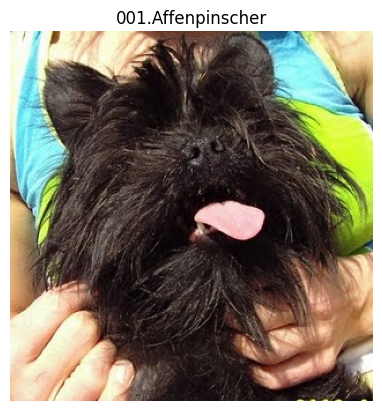

In [102]:
# TODO: Run an prediction on the endpoint

image_file_path = 'dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg'

with open(image_file_path, 'rb') as file:
    image_bytes = file.read()

image_data = Image.open(io.BytesIO(image_bytes))
# image_data.resize((22, 22))

actual_label = image_file_path.split('/')[2] 

plt.imshow(image_data)
plt.axis('off')
plt.title(actual_label)  
plt.show()

In [116]:
response=predictor.predict(image_bytes, initial_args={"ContentType": "image/jpeg"})

label_names = sorted(os.listdir('dogImages/test'))
predictions = list(enumerate(response[0]))
predictions.sort(key=lambda x: 1.0 - x[1])
print(f"Predict: {label_names[predictions[0][0]]}")


Predicted label: 133.Yorkshire_terrier


In [118]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

[12/01/24 16:26:05] INFO     Deleting endpoint configuration with name:                             ]8;id=242147;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=293275;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/session.py#4796\4796]8;;\
                             pytorch-inference-2024-12-01-16-14-20-348                                             

                    INFO     Deleting endpoint with name: pytorch-inference-2024-12-01-16-14-20-348 ]8;id=978800;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=339344;file:///home/ec2-user/SageMaker/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/myenv/lib/python3.10/site-packages/sagemaker/session.py#4786\4786]8;;\